# Tweeter posts analysis

In [219]:
!pip install -q tweepy python-dotenv spacy spacytextblob nltk stanza

27734.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [220]:
import dotenv

dotenv.load_dotenv()

True

## Tweets fetching

In [221]:
import tweepy
import os

bareer = os.getenv("X_BAREER")

client = tweepy.Client(bearer_token=bareer)
user = client.get_user(username="elonmusk")
id = user.data.id
display(id)

44196397

In [222]:
response = client.get_users_tweets(id=str(id), max_results=100)

In [223]:
import pandas as pd

rows = [["Elon Musk", str(tweet)] for tweet in response.data]

df = pd.DataFrame(data=rows, columns=["author", "tweets"])

df.to_csv("elon_musk_tweets.csv", sep=",", index=False)

## Data cleaning

In [224]:
# remove stopwords, tokenize
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)

stopwords = stopwords.words("english")

tweets_tokens = []
tweets = df.tweets.to_list()
tokenizer = nltk.tokenize.TweetTokenizer(
    preserve_case=False, strip_handles=True, reduce_len=True
)
for t in tweets:
    tokens = tokenizer.tokenize(t)
    tokens = [t for t in tokens if t not in stopwords]
    tweets_tokens.append(tokens)

for tweet in tweets_tokens[:5]:
    print(tweet)

['goes', 'norway', ',', 'goes', 'rest', 'world', '.', 'combustion', 'engine', 'cars', 'like', 'steam', 'engine', '–', 'quaint', ',', 'primitive', '.', 'https://t.co/yOuduv8YWK']
['29', 'landings', 'single', 'booster', '!', 'https://t.co/N0JeiwCMlm']
['rt', ':', 'engineered', 'durability', ',', 'performance', 'designed', 'ruggedized', 'solution', 'customers', 'require', 'reliable', ',', 'high-spee', '…']
['starlink', 'available', 'sri', 'lanka', '!', '🇱🇰', 'https://t.co/37X5hNOEfL']
['😉']


In [225]:
df["tweets_tokens"] = tweets_tokens
original_len = len(df)

# remove tweets shorter than 5 tokens as from my first analysis it comes out that those are mostly emogis always classified as 'Neutral'
min_tokens = 3
df = df[df["tweets_tokens"].apply(lambda x: len(x) >= min_tokens)]
new_len = len(df)

print(f"Number of rows removed: {original_len - new_len}")
df.head()

Number of rows removed: 47


,author,tweets,tweets_tokens
0,Elon Musk,"As goes Norway, so goes the rest of the world....","[goes, norway, ,, goes, rest, world, ., combus..."
1,Elon Musk,29 landings of single booster! https://t.co/N0...,"[29, landings, single, booster, !, https://t.c..."
2,Elon Musk,"RT @Starlink: Engineered for durability, Perfo...","[rt, :, engineered, durability, ,, performance..."
3,Elon Musk,Starlink now available in Sri Lanka! 🇱🇰 https:...,"[starlink, available, sri, lanka, !, 🇱🇰, https..."
5,Elon Musk,RT @SawyerMerritt: NEWS: Tesla has released it...,"[rt, :, news, :, tesla, released, 2024, annual..."


## Sentiment analysis with spaCY

In [226]:
!python -m textblob.download_corpora;
!python -m spacy download en_core_web_sm;

27726.79s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


/home/marcin/projects/WSEI-NLP/.venv/lib/python3.12/site-packages/nltk/metrics/association.py:26: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.stats import fisher_exact
[nltk_data] Downloading package brown to /home/marcin/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/marcin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /home/marcin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/marcin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /home/marcin/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_d

27744.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 41.7 MB/s eta 0:00:0000:010:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import spacy

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("spacytextblob")

threshold = 0.1 # this value seems pretty low but in fact spacy is conservative in terms of polarization values and most of them are close to 0

spacy_sentiment_stats = {"Positive": 0, "Neutral": 0, "Negative": 0}

for text in df.tweets:
    print(100 * "=")
    doc = nlp(text)
    print(text)
    # display(f"Subjectivity {doc._.blob.subjectivity}")
    # display(f"Assesments: {doc._.blob.sentiment_assessments.assessments}")
    sentiment_value = doc._.blob.polarity
    sentiment = (
        "Negative"
        if sentiment_value < -threshold
        else "Neutral" if -threshold <= sentiment_value <= threshold else "Positive"
    )
    spacy_sentiment_stats[sentiment] += 1
    print(f"\nSentiment: {sentiment_value:.2f} = {sentiment}")

As goes Norway, so goes the rest of the world. 

Combustion engine cars will be like the steam engine – quaint, but primitive. https://t.co/yOuduv8YWK

Sentiment: 0.00 = Neutral
29 landings of single booster! https://t.co/N0JeiwCMlm

Sentiment: -0.09 = Neutral
RT @Starlink: Engineered for durability, Performance was designed to be a ruggedized solution for customers who require reliable, high-spee…

Sentiment: 0.00 = Neutral
Starlink now available in Sri Lanka! 🇱🇰 https://t.co/37X5hNOEfL

Sentiment: 0.50 = Positive
RT @SawyerMerritt: NEWS: Tesla has released its 2024 annual impact report. It's 42.0 pages long (naturally lol). I'll post all the highligh…

Sentiment: 0.38 = Positive
RT @teslaownersSV: Every failure builds greatness keep going Elon https://t.co/1KBeZi582I

Sentiment: -0.32 = Negative
Credit where credit is due. 

@realDonaldTrump has successfully resolved several serious conflicts around the world. https://t.co/0EyHHy5Gfo

Sentiment: 0.07 = Neutral
@daltybrewer Just plain

Looks like it does not get sarcazm:\
*"@realDonaldTrump has successfully resolved several serious conflicts around the world. https://t.co/0EyHHy5Gfo*

Sentiment: **0.07 = Positive**"

Or maybe it wasn't a joke...

In [228]:
spacy_sentiment_stats

{'Positive': 13, 'Neutral': 33, 'Negative': 7}

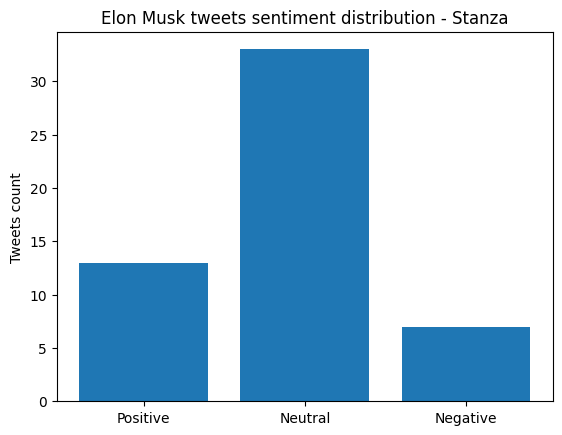

In [229]:
import matplotlib.pyplot as plt

plt.title("Elon Musk tweets sentiment distribution - Stanza")
plt.bar(spacy_sentiment_stats.keys(), spacy_sentiment_stats.values())
plt.ylabel("Tweets count")
plt.show()

## Linguistic and Sentiment Analysis using Stanza

In [230]:
import stanza
import random

stanza_sentiment_stats = {"Positive": 0, "Neutral": 0, "Negative": 0}

stanza_sentiment_idx = {2: "Positive", 1: "Neutral", 0: "Negative"}

# stanza returns sentiment for each sentese so I will do majority voting
nlp = stanza.Pipeline(lang="en", processors=["sentiment", "tokenize"])
for idx, text in df.tweets.items():
    doc = nlp(text)

    sentiment_counter = {"Positive": 0, "Neutral": 0, "Negative": 0}
    for i, sentence in enumerate(doc.sentences):
        sentiment_value = sentence.sentiment
        sentiment_name = stanza_sentiment_idx[sentiment_value]
        sentiment_counter[sentiment_name] += 1

    sentiment_counter = dict(
        sorted(sentiment_counter.items(), key=lambda item: item[1], reverse=True)
    )
    major_sentiments = []
    max_value = max(sentiment_counter.values())
    for k, v in sentiment_counter.items():
        if v != max_value:
            break
        major_sentiments.append(k)
    tweet_sentiment = random.choice(
        major_sentiments
    )  # choose one if there are many major sentiments
    stanza_sentiment_stats[tweet_sentiment] += 1

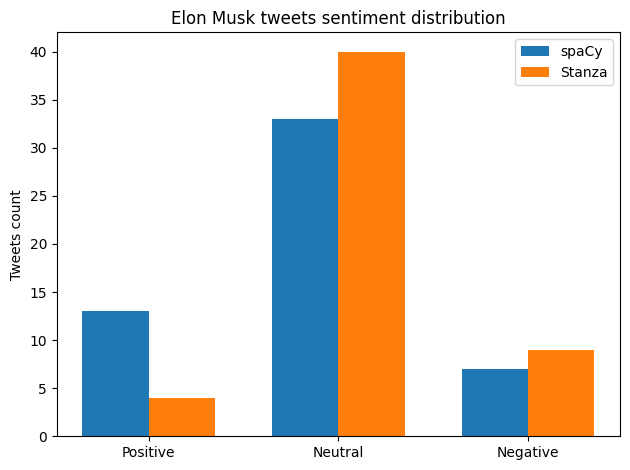

In [231]:
import numpy as np


labels = list(spacy_sentiment_stats.keys())
spacy_values = list(spacy_sentiment_stats.values())
stanza_values = list(stanza_sentiment_stats.values())

x = np.arange(len(labels))  # [0, 1, 2]
width = 0.35

fig, ax = plt.subplots()
spacy_bars = ax.bar(x - width / 2, spacy_values, width, label="spaCy")
stanza_bars = ax.bar(x + width / 2, stanza_values, width, label="Stanza")

ax.set_ylabel("Tweets count")
ax.set_title("Elon Musk tweets sentiment distribution")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

### Lemantization

In [232]:
import stanza

lemma_map = {}

nlp = stanza.Pipeline(lang="en", processors=["lemma", "tokenize"], verbose=False)
for idx, text in df.tweets[:10].items():
    doc = nlp(text)
    for sentence in doc.to_dict():
        for word in sentence:
            if word.get("lemma", False):
                lemma_map[word["text"]] = word["lemma"]

In [233]:
# cases when lemmantic form is not used
{k: v for k, v in lemma_map.items() if k != v}

{'As': 'as',
 'goes': 'go',
 'Combustion': 'combustion',
 'cars': 'car',
 '–': '-',
 'landings': 'landing',
 'RT': 'rt',
 '@Starlink': '@starlink',
 'Engineered': 'engineered',
 'Performance': 'performance',
 'was': 'be',
 'designed': 'design',
 'customers': 'customer',
 'Starlink': 'starlink',
 '@SawyerMerritt': '@sawyermerritt',
 'NEWS': 'news',
 'has': 'have',
 'released': 'release',
 'It': 'it',
 'pages': 'page',
 "'ll": 'will',
 'Every': 'every',
 'builds': 'build',
 'going': 'go',
 'Elon': 'elon',
 'Credit': 'credit',
 'is': 'be',
 'resolved': 'resolve',
 'conflicts': 'conflict',
 'Just': 'just',
 'So': 'so',
 'JessePeltan': 'jessepeltan',
 'Maybe': 'maybe',
 'Gigafactory': 'gigafactory',
 'Let': 'let',
 '’s': "'s",
 'spending': 'spend',
 'means': 'mean',
 'That': 'that'}

## Named Entity Recognition (NER)

In [234]:
# using Stanza
import stanza

stanza_ner_map = {}

nlp = stanza.Pipeline(lang="en", processors=["tokenize", "ner"], verbose=False)
for idx, text in df.tweets[:10].items():
    doc = nlp(text)
    for sentence in doc.to_dict():
        for word in sentence:
            if word.get("ner", False):
                stanza_ner_map[word["text"]] = word["ner"]

In [235]:
print(set(list(stanza_ner_map.values())))

# only not "Outside" objects
{k: v for k, v in stanza_ner_map.items() if v != "O"}

{'O', 'S-DATE', 'S-GPE', 'S-PERSON', 'B-GPE', 'S-CARDINAL', 'E-GPE', 'E-ORG', 'S-ORG'}


{'Norway': 'S-GPE',
 '29': 'S-CARDINAL',
 'Starlink': 'S-ORG',
 'Sri': 'B-GPE',
 'Lanka': 'E-GPE',
 '@SawyerMerritt': 'E-ORG',
 'Tesla': 'S-ORG',
 '2024': 'S-DATE',
 '42.0': 'S-CARDINAL',
 'Elon': 'S-ORG',
 '@realDonaldTrump': 'S-ORG',
 'JessePeltan': 'S-PERSON',
 'Gigafactory': 'S-ORG',
 'America': 'S-GPE'}

In [236]:
# using spacy
import spacy

spacy_ner_map = {}
nlp = spacy.load("en_core_web_sm")

for text in df.tweets:
    doc = nlp(text)
    for ent in doc.ents:
        spacy_ner_map[ent.text] = ent.label_

In [237]:
print(set(list(spacy_ner_map.values())))
spacy_ner_map

{'ORDINAL', 'GPE', 'DATE', 'MONEY', 'ORG', 'CARDINAL', 'NORP', 'PRODUCT', 'PERCENT', 'WORK_OF_ART', 'PERSON', 'QUANTITY', 'TIME', 'LOC'}


{'Norway': 'GPE',
 'https://t.co/yOuduv8YWK': 'PERSON',
 '29': 'CARDINAL',
 'Performance': 'PERSON',
 'Sri Lanka': 'GPE',
 '2024': 'DATE',
 '42.0': 'CARDINAL',
 'Elon https://t.co/1KBeZi582I': 'PRODUCT',
 'America': 'GPE',
 'Senate': 'ORG',
 'House': 'ORG',
 'Falcon': 'ORG',
 'the Just Read the Instructions': 'WORK_OF_ART',
 'AI': 'GPE',
 'today': 'DATE',
 'RT @SenRandPaul: Throughout the Vote': 'PERSON',
 'all night': 'TIME',
 'Congress': 'ORG',
 'Tesla': 'ORG',
 'first': 'ORDINAL',
 'this quarter': 'DATE',
 '@ns123abc': 'GPE',
 'RT @Kalshi': 'PERSON',
 '2025': 'DATE',
 '41%': 'PERCENT',
 'Elon': 'ORG',
 '@merricklackner': 'NORP',
 'Bannon': 'PERSON',
 'Bill': 'PERSON',
 '860,000': 'CARDINAL',
 'Mars': 'LOC',
 '2': 'MONEY',
 'Doge': 'PERSON',
 '160B': 'MONEY',
 '5': 'MONEY',
 'CAD': 'ORG',
 'RT @MarioNawfal:': 'PERSON',
 '🇸': 'PERSON',
 'MIND-BLOWING FEDERAL BUDGET BREAKDOWN': 'ORG',
 '6.16': 'MONEY',
 '4.47': 'MONEY',
 'TRILLION': 'ORG',
 'fiscal 202': 'DATE',
 '@creepydotorg Differe

|SpaCy|Stanza|
|---|---|
|✅ 14 entities recognized|❌ 9 entities recognized (including same entity begining **B** and its end **E**)|
|✅ better handling of multi-token entities|❌ each multi token entity is splitted|
|✅ nice API|❌ returns dicts with inconsistant keys|
|✅ works for whole documents|❌ splits text into sentences|



My personal favourite is tududu **SpaCy**!!